# Data hypotheses, revisited

The family of models we use here have some fundamental assumptions:

Assumption 1 - there is a positive correlation between post-treatment time and neutrophil count. This means that the neutrophil count will be lowest immediately after treatment, and will tend to recover following the end of treatment. Biologically, this means that ven/aza treatment negatively affects neutrophil count, and that neutrophil count recovers after the end of treatment.

Assumption 2 - there is a negative correlation between blast count and neutrophil count. Biologically, this means that a high level of bone marrow leukemic blasts will negatively affect neutrophil production.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import sys
sys.path.append('../')

## Load data

In [2]:
# sheet names: Blood_counts, Bone_marrow_blasts, Cycle_days, TLS_lab_C1D2leuk, Annotations
blood_counts = pd.read_csv('../patient_data_venex/blood_counts_table.csv')
bm_blasts = pd.read_csv('../patient_data_venex/blasts_table.csv')
cycle_days = pd.read_csv('../patient_data_venex/cycle_days.csv')

## Get hypotheses for all patients

In [3]:
from new_patient_model import extract_data_from_tables_new

### Neutrophil count vs blast count

In [4]:
# TODO: map times between bone marrow blast measurements and blood measurements for the same patient

In [5]:
patient_ids = blood_counts['AnonymizedID'].unique()

In [6]:
len(patient_ids)

104

In [7]:
patient_data = {}
patient_data_matched = {}

In [8]:
# interpolate bm_blasts?
import scipy.interpolate

In [9]:
# now, do this for all patients...
neut_blast_correlations = {}
neut_blast_spearman_correlations = {}
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)
    patient_data[patient_id] = leuk_table

    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue
    # interpolate bone marrow results
    bm_blast_interpolator = scipy.interpolate.PchipInterpolator(blast_table['days_from_bm'], blast_table['bm_blasts'])
    lab_results_matched = leuk_table[leuk_table.days_lab <= blast_table.days_from_bm.max()].copy()
    bm_blasts_interpolated = bm_blast_interpolator(lab_results_matched['days_lab'])
    lab_results_matched['bm_blasts_interpolated'] = bm_blasts_interpolated
    patient_data_matched[patient_id] = lab_results_matched
    correlation = scipy.stats.pearsonr(lab_results_matched['b_neut'], lab_results_matched['bm_blasts_interpolated'])
    neut_blast_correlations[patient_id] = correlation
    neut_blast_spearman_correlations[patient_id] = scipy.stats.spearmanr(lab_results_matched['b_neut'],
                                                                lab_results_matched['bm_blasts_interpolated'])

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



#### Pearson - all patients

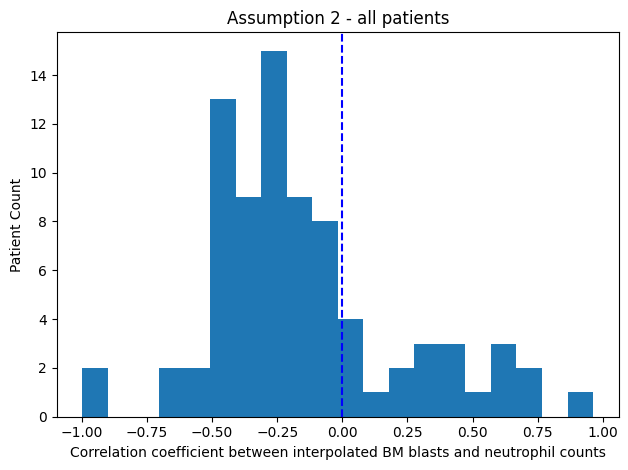

In [10]:
plt.hist([x.statistic for x in neut_blast_correlations.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - all patients')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [11]:
neut_blast_corr_vals = neut_blast_correlations.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.7439024390243902 of patients
positive correlations:  0.23170731707317074 of patients


In [12]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=61, n=82, alternative='two-sided', statistic=0.7439024390243902, pvalue=1.1296023055413025e-05)

#### Pearson - >5 points

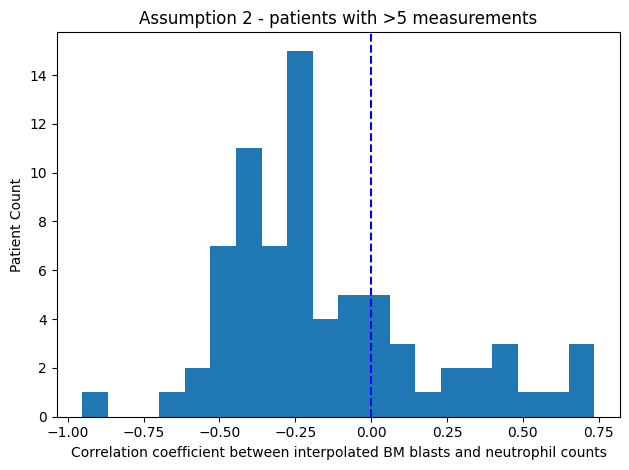

In [13]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations.items() if len(patient_data[pid]) > 5}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >5 measurements')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [14]:
len(correlation_subset)

76

In [15]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.75 of patients
positive correlations:  0.2236842105263158 of patients


In [16]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=57, n=76, alternative='two-sided', statistic=0.75, pvalue=1.4836899336372366e-05)

#### Pearson - >= 20 points

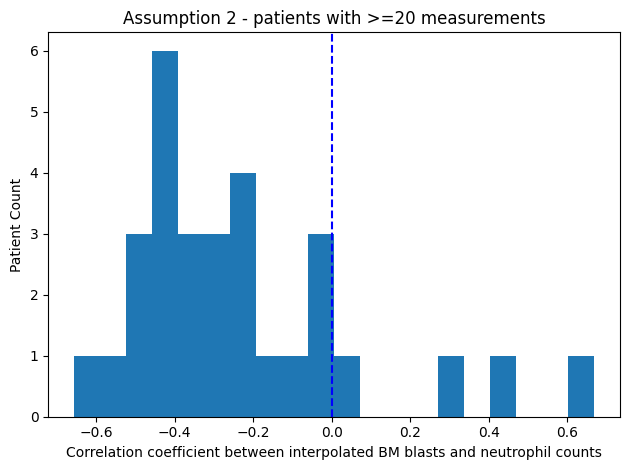

In [17]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations.items() if len(patient_data[pid]) >=20}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >=20 measurements')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [18]:
len(correlation_subset)

32

In [19]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.8125 of patients
positive correlations:  0.125 of patients


In [20]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=26, n=32, alternative='two-sided', statistic=0.8125, pvalue=0.0005350527353584766)

#### Pearson - p<0.05

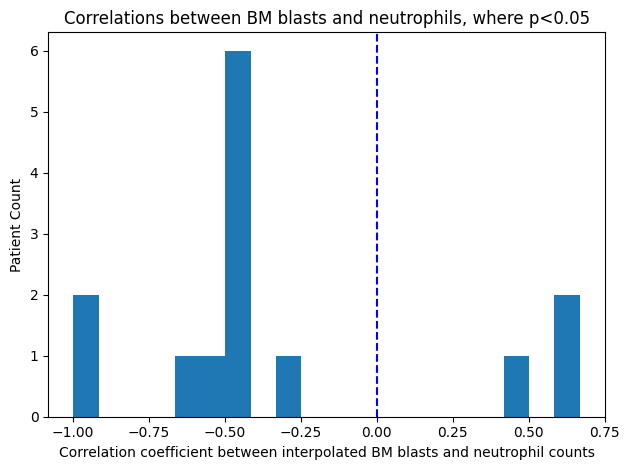

In [21]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations.items() if x.pvalue<0.05}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Correlations between BM blasts and neutrophils, where p<0.05')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [22]:
len(correlation_subset)

14

In [23]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.7857142857142857 of patients
positive correlations:  0.21428571428571427 of patients


In [24]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=11, n=14, alternative='two-sided', statistic=0.7857142857142857, pvalue=0.057373046875)

#### Spearman - all patients

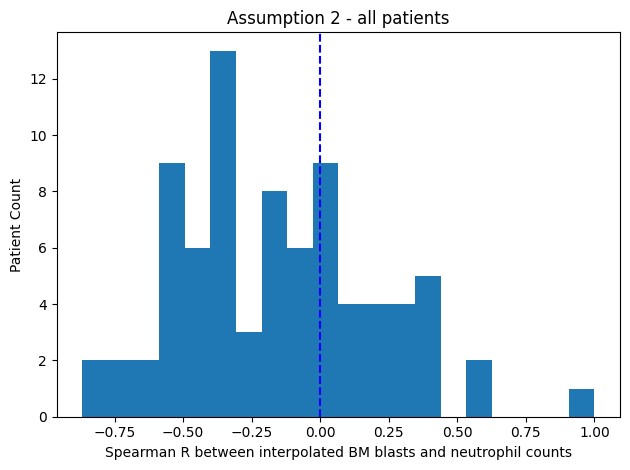

In [25]:
plt.hist([x.statistic for x in neut_blast_spearman_correlations.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - all patients')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [26]:
neut_blast_corr_vals = neut_blast_correlations.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.7439024390243902 of patients
positive correlations:  0.23170731707317074 of patients


In [27]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=61, n=82, alternative='two-sided', statistic=0.7439024390243902, pvalue=1.1296023055413025e-05)

#### Spearman - >5 points

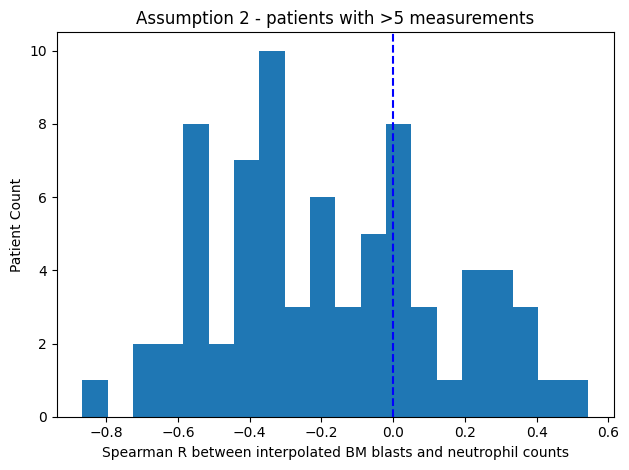

In [28]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations.items() if len(patient_data[pid]) > 5}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >5 measurements')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [29]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.6973684210526315 of patients
positive correlations:  0.2631578947368421 of patients


In [30]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=53, n=76, alternative='two-sided', statistic=0.6973684210526315, pvalue=0.0007645817391550476)

#### Spearman - >= 20 points

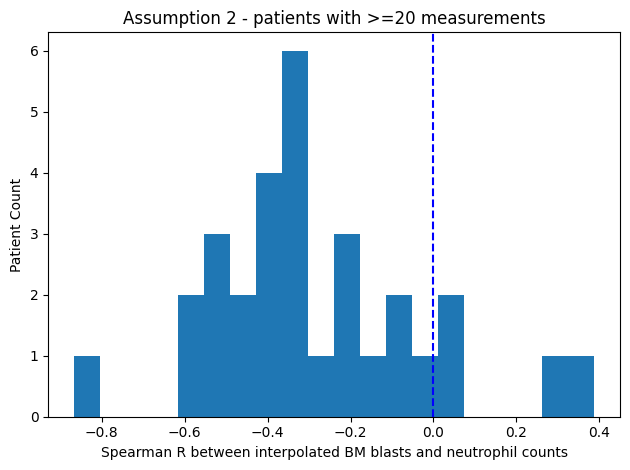

In [31]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations.items() if len(patient_data[pid]) >= 20}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >=20 measurements')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [32]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.8125 of patients
positive correlations:  0.125 of patients


In [33]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=26, n=32, alternative='two-sided', statistic=0.8125, pvalue=0.0005350527353584766)

#### Spearman - p<0.05

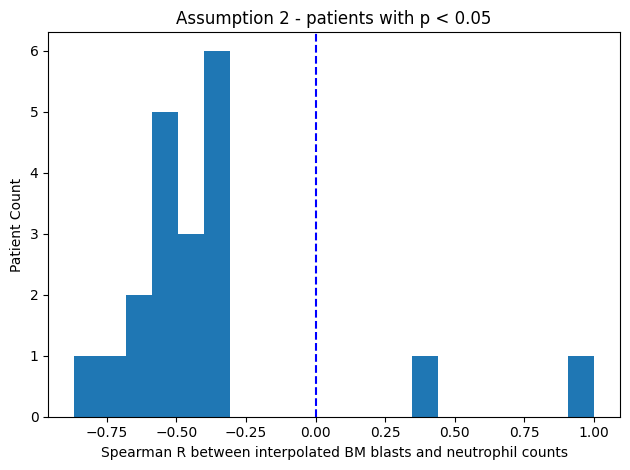

In [34]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations.items() if x.pvalue < 0.05}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with p < 0.05')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [35]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.9 of patients
positive correlations:  0.1 of patients


In [36]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=18, n=20, alternative='two-sided', statistic=0.9, pvalue=0.0004024505615234375)

In [37]:
print(neut_blast_corr_vals)

dict_values([SignificanceResult(statistic=-0.5573056718431768, pvalue=0.005733087143797736), SignificanceResult(statistic=-0.34686649345273207, pvalue=0.02441777631629237), SignificanceResult(statistic=-0.4458978207943051, pvalue=0.0014916517147104918), SignificanceResult(statistic=-0.5796951885499024, pvalue=0.03784464645268356), SignificanceResult(statistic=-0.3361509957806553, pvalue=0.015877228947130936), SignificanceResult(statistic=-0.5420493789363714, pvalue=0.009162140367121244), SignificanceResult(statistic=-0.3213972969215986, pvalue=0.01572077864659795), SignificanceResult(statistic=1.0, pvalue=0.0), SignificanceResult(statistic=-0.7192186269636924, pvalue=0.0007681904189507868), SignificanceResult(statistic=-0.5980609205722571, pvalue=0.011217376736646273), SignificanceResult(statistic=-0.3845015693772062, pvalue=0.017149454004391145), SignificanceResult(statistic=-0.3778402855660821, pvalue=0.016227576541635477), SignificanceResult(statistic=-0.3482624729784637, pvalue=0.0

In these graphs, each bar-step is a patient, indicating the correlation between bone marrow blast count (interpolated) and neutrophil count for that patient.

Interpolation was done using the "PCHIP 1-D monotonic cubic interpolation" from scikit-learn - for all control points, the interpolated and actual values are the same.

#### Conclusions:

- Neutrophil counts and bone marrow blast counts are inversely correlated. This indicates some negative effect of blasts on neutrophil production.
- We don't know the time scale of this relationship... maybe it's a lagged relationship?
- Thus, we expect higher bm blasts to inhibit neutrophil production for most patients. This possibly supercedes the known inhibitory effect of venetoclax on neutrophil production.
- Spearman correlations are more negative than Pearson correlations across different data counts
- Among the "significant" correlations, there were some that had significantly positive correlations, which is not what we expect. In these cases, are the blasts less inhibitory towards healthy blood cell production?

TODO:

- ~~correlation between time-since-treatment and neutrophil count?~~ - done
- Can we predict neutrophil count based on a multiple regression of interpolated blast count and time-since-treatment?

### Neutrophil count vs blast count - no interpolation, 5 or 10-day window

In [38]:
# now, do this for all patients...
neut_blast_correlations_nointerp = {}
neut_blast_spearman_correlations_nointerp = {}
patient_data_nointerp = {}
patient_data_matched_nointerp = {}
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)
    patient_data_nointerp[patient_id] = leuk_table
    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue
    # interpolate bone marrow results
    # TODO: for every blast measurement, find the nearest neutrophil time...
    matched_blasts = []
    matched_neuts = []
    matched_rows = []
    for _, blast_row in blast_table.iterrows():
        for _, leuk_row in leuk_table.iterrows():
            if abs(blast_row.days_from_bm - leuk_row.days_lab) <= 5:
                matched_blasts.append(blast_row.bm_blasts)
                matched_neuts.append(leuk_row.b_neut)
                matched_rows.append((blast_row, leuk_row))
                break
    if len(matched_neuts) < 2:
        continue
    patient_data_matched_nointerp[patient_id] = matched_rows
    correlation = scipy.stats.pearsonr(matched_neuts, matched_blasts)
    neut_blast_correlations_nointerp[patient_id] = correlation
    neut_blast_spearman_correlations_nointerp[patient_id] = scipy.stats.spearmanr(matched_neuts,
                                                                matched_blasts)
    print(patient_id, neut_blast_spearman_correlations_nointerp[patient_id])

8013 SignificanceResult(statistic=-0.39405520311955033, pvalue=0.38173649344725374)
3028 SignificanceResult(statistic=0.5, pvalue=0.6666666666666667)
4046 SignificanceResult(statistic=0.9999999999999999, pvalue=nan)
5055 SignificanceResult(statistic=0.10540925533894598, pvalue=0.894590744661054)
6067 SignificanceResult(statistic=-0.4481997347249388, pvalue=0.10799196544671771)
6074 SignificanceResult(statistic=0.6668859288553503, pvalue=0.21889398131323154)
6086 SignificanceResult(statistic=-0.10540925533894598, pvalue=0.894590744661054)
4098 SignificanceResult(statistic=-0.4394802124588286, pvalue=0.383220913257781)
3101 SignificanceResult(statistic=-0.48556905942614514, pvalue=0.07837831895474086)
3114 SignificanceResult(statistic=-0.23684210526315794, pvalue=0.7012867390780669)
5128 SignificanceResult(statistic=0.0, pvalue=1.0)
4132 SignificanceResult(statistic=-0.18136906252750293, pvalue=0.7703461020137523)
9145 SignificanceResult(statistic=-0.46291004988627577, pvalue=0.111172952

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



8242 SignificanceResult(statistic=-0.511207720338155, pvalue=0.1595559476434325)
9250 SignificanceResult(statistic=-1.0, pvalue=0.0)
3266 SignificanceResult(statistic=0.0, pvalue=1.0)
5276 SignificanceResult(statistic=0.39999999999999997, pvalue=0.6)
3339 SignificanceResult(statistic=1.0, pvalue=0.0)
9357 SignificanceResult(statistic=-0.39279220242478635, pvalue=0.4411128091213043)
3360 SignificanceResult(statistic=-0.445896321370523, pvalue=0.3754828581275207)
6374 SignificanceResult(statistic=0.07142857142857144, pvalue=0.8790481931481541)
8386 SignificanceResult(statistic=1.0, pvalue=0.0)
1393 SignificanceResult(statistic=-0.3354101966249684, pvalue=0.5810906728217108)
7402 SignificanceResult(statistic=0.30425553170226594, pvalue=0.5576993870568202)
6416 SignificanceResult(statistic=0.05241424183609592, pvalue=0.8649667720135804)
3447 SignificanceResult(statistic=0.13093073414159545, pvalue=0.8047261622231061)
6450 SignificanceResult(statistic=-0.8116794499134279, pvalue=0.049857585

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



8725 SignificanceResult(statistic=-0.7815126050420169, pvalue=0.012867279304135634)
6735 SignificanceResult(statistic=0.44721359549995787, pvalue=0.45018485575210093)
9744 SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)
7773 SignificanceResult(statistic=-0.7229684624403735, pvalue=0.042721089466964596)
6780 SignificanceResult(statistic=-0.25043516133890464, pvalue=0.5496980817921229)
8793 SignificanceResult(statistic=-0.11118739749916519, pvalue=0.8124070154613051)
6804 SignificanceResult(statistic=0.037062465833055065, pvalue=0.9371240086628561)
9823 SignificanceResult(statistic=-0.15389675281277312, pvalue=0.8048288166080632)
4838 SignificanceResult(statistic=-0.5443310539518174, pvalue=0.45566894604818264)
3841 SignificanceResult(statistic=0.3188740696088466, pvalue=0.5379005604702051)
9851 SignificanceResult(statistic=-0.5500190982169268, pvalue=0.12496097654595255)
2886 SignificanceResult(statistic=0.5, pvalue=0.6666666666666667)
3895 SignificanceResult(statistic=0.5

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [39]:
# now, do this for all patients...
neut_blast_correlations_nointerp_2_window = {}
neut_blast_spearman_correlations_nointerp_2_window = {}
patient_data_nointerp_2_window = {}
patient_data_matched_nointerp_2_window = {}
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)
    patient_data_nointerp_2_window[patient_id] = leuk_table
    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue
    # interpolate bone marrow results
    # TODO: for every blast measurement, find the nearest neutrophil time...
    matched_blasts = []
    matched_neuts = []
    matched_rows = []
    for _, blast_row in blast_table.iterrows():
        for _, leuk_row in leuk_table.iterrows():
            if abs(blast_row.days_from_bm - leuk_row.days_lab) <= 2:
                matched_blasts.append(blast_row.bm_blasts)
                matched_neuts.append(leuk_row.b_neut)
                matched_rows.append((blast_row, leuk_row))
                break
    if len(matched_neuts) < 2:
        continue
    patient_data_matched_nointerp_2_window[patient_id] = matched_rows
    correlation = scipy.stats.pearsonr(matched_neuts, matched_blasts)
    neut_blast_correlations_nointerp_2_window[patient_id] = correlation
    neut_blast_spearman_correlations_nointerp_2_window[patient_id] = scipy.stats.spearmanr(matched_neuts,
                                                                matched_blasts)
    print(patient_id, neut_blast_spearman_correlations_nointerp[patient_id])

8013 SignificanceResult(statistic=-0.39405520311955033, pvalue=0.38173649344725374)
3028 SignificanceResult(statistic=0.5, pvalue=0.6666666666666667)
4046 SignificanceResult(statistic=0.9999999999999999, pvalue=nan)
5055 SignificanceResult(statistic=0.10540925533894598, pvalue=0.894590744661054)
6067 SignificanceResult(statistic=-0.4481997347249388, pvalue=0.10799196544671771)
6074 SignificanceResult(statistic=0.6668859288553503, pvalue=0.21889398131323154)
6086 SignificanceResult(statistic=-0.10540925533894598, pvalue=0.894590744661054)
4098 SignificanceResult(statistic=-0.4394802124588286, pvalue=0.383220913257781)
3101 SignificanceResult(statistic=-0.48556905942614514, pvalue=0.07837831895474086)
3114 SignificanceResult(statistic=-0.23684210526315794, pvalue=0.7012867390780669)
5128 SignificanceResult(statistic=0.0, pvalue=1.0)
4132 SignificanceResult(statistic=-0.18136906252750293, pvalue=0.7703461020137523)
9145 SignificanceResult(statistic=-0.46291004988627577, pvalue=0.111172952

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



8216 SignificanceResult(statistic=-0.46291004988627577, pvalue=0.11117295276905703)
5224 SignificanceResult(statistic=-0.8660254037844387, pvalue=0.3333333333333332)
8242 SignificanceResult(statistic=-0.511207720338155, pvalue=0.1595559476434325)
9250 SignificanceResult(statistic=-1.0, pvalue=0.0)
3266 SignificanceResult(statistic=0.0, pvalue=1.0)
5276 SignificanceResult(statistic=0.39999999999999997, pvalue=0.6)
3339 SignificanceResult(statistic=1.0, pvalue=0.0)
9357 SignificanceResult(statistic=-0.39279220242478635, pvalue=0.4411128091213043)
3360 SignificanceResult(statistic=-0.445896321370523, pvalue=0.3754828581275207)
6374 SignificanceResult(statistic=0.07142857142857144, pvalue=0.8790481931481541)
8386 SignificanceResult(statistic=1.0, pvalue=0.0)
1393 SignificanceResult(statistic=-0.3354101966249684, pvalue=0.5810906728217108)
7402 SignificanceResult(statistic=0.30425553170226594, pvalue=0.5576993870568202)
6416 SignificanceResult(statistic=0.05241424183609592, pvalue=0.8649667

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



8725 SignificanceResult(statistic=-0.7815126050420169, pvalue=0.012867279304135634)
6735 SignificanceResult(statistic=0.44721359549995787, pvalue=0.45018485575210093)
9744 SignificanceResult(statistic=-0.9999999999999999, pvalue=nan)
7773 SignificanceResult(statistic=-0.7229684624403735, pvalue=0.042721089466964596)
6780 SignificanceResult(statistic=-0.25043516133890464, pvalue=0.5496980817921229)
8793 SignificanceResult(statistic=-0.11118739749916519, pvalue=0.8124070154613051)
6804 SignificanceResult(statistic=0.037062465833055065, pvalue=0.9371240086628561)
9823 SignificanceResult(statistic=-0.15389675281277312, pvalue=0.8048288166080632)
4838 SignificanceResult(statistic=-0.5443310539518174, pvalue=0.45566894604818264)
3841 SignificanceResult(statistic=0.3188740696088466, pvalue=0.5379005604702051)
9851 SignificanceResult(statistic=-0.5500190982169268, pvalue=0.12496097654595255)
2886 SignificanceResult(statistic=0.5, pvalue=0.6666666666666667)
3895 SignificanceResult(statistic=0.5

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [40]:
# now, do this for all patients...
neut_blast_correlations_nointerp_10_window = {}
neut_blast_spearman_correlations_nointerp_10_window = {}
patient_data_nointerp_10_window = {}
patient_data_matched_nointerp_10_window = {}
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)
    patient_data_nointerp_10_window[patient_id] = leuk_table
    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue
    # interpolate bone marrow results
    # TODO: for every blast measurement, find the nearest neutrophil time...
    matched_blasts = []
    matched_neuts = []
    matched_rows = []
    for _, blast_row in blast_table.iterrows():
        for _, leuk_row in leuk_table.iterrows():
            if abs(blast_row.days_from_bm - leuk_row.days_lab) <= 10:
                matched_blasts.append(blast_row.bm_blasts)
                matched_neuts.append(leuk_row.b_neut)
                matched_rows.append((blast_row, leuk_row))
                break
    if len(matched_neuts) < 2:
        continue
    patient_data_matched_nointerp_10_window[patient_id] = matched_rows
    correlation = scipy.stats.pearsonr(matched_neuts, matched_blasts)
    neut_blast_correlations_nointerp_10_window[patient_id] = correlation
    neut_blast_spearman_correlations_nointerp_10_window[patient_id] = scipy.stats.spearmanr(matched_neuts,
                                                                matched_blasts)
    print(patient_id, neut_blast_spearman_correlations_nointerp_10_window[patient_id])

8013 SignificanceResult(statistic=-0.1391674851853202, pvalue=0.7660231518571954)
3028 SignificanceResult(statistic=0.5, pvalue=0.6666666666666667)
4046 SignificanceResult(statistic=0.8660254037844387, pvalue=0.3333333333333332)
5055 SignificanceResult(statistic=0.10540925533894598, pvalue=0.894590744661054)
6067 SignificanceResult(statistic=-0.4481997347249388, pvalue=0.10799196544671771)
6074 SignificanceResult(statistic=0.6668859288553503, pvalue=0.21889398131323154)
6086 SignificanceResult(statistic=-0.10540925533894598, pvalue=0.894590744661054)
4098 SignificanceResult(statistic=-0.4394802124588286, pvalue=0.383220913257781)
3101 SignificanceResult(statistic=-0.48556905942614514, pvalue=0.07837831895474086)
3114 SignificanceResult(statistic=-0.23684210526315794, pvalue=0.7012867390780669)
5128 SignificanceResult(statistic=0.0, pvalue=1.0)
4132 SignificanceResult(statistic=0.0, pvalue=1.0)
9145 SignificanceResult(statistic=-0.46291004988627577, pvalue=0.11117295276905703)
5157 Sign

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/yzhang/.pyenv/versions/3.10.6/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



#### Pearson - all patients

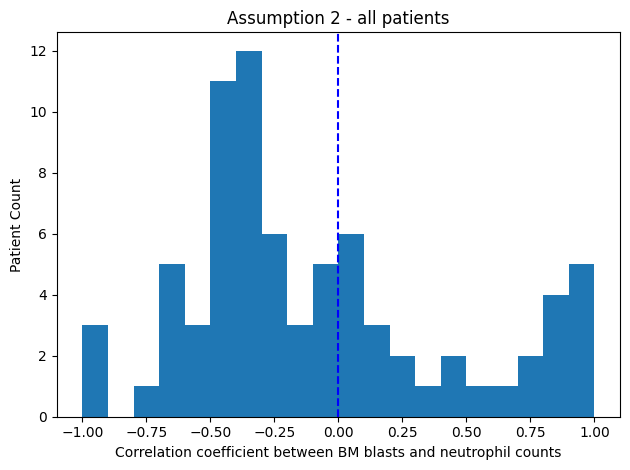

In [41]:
plt.hist([x.statistic for x in neut_blast_correlations_nointerp.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - all patients')
plt.xlabel('Correlation coefficient between BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [42]:
neut_blast_corr_vals = neut_blast_correlations_nointerp.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.6125 of patients
positive correlations:  0.3375 of patients


In [43]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=49, n=80, alternative='two-sided', statistic=0.6125, pvalue=0.056664426345121144)

#### Pearson - >5 points

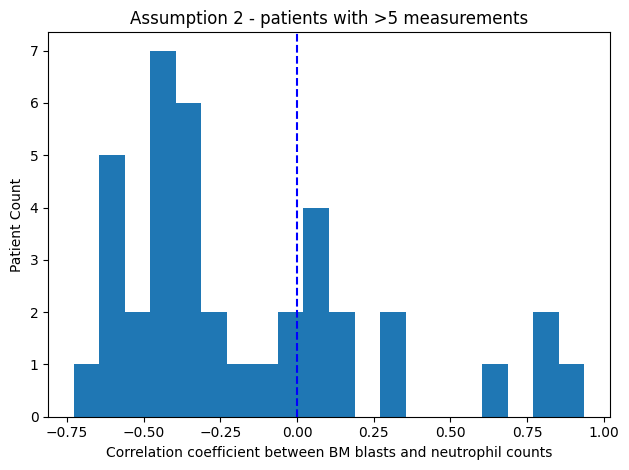

In [44]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations_nointerp.items() if len(patient_data_matched_nointerp[pid]) > 5}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >5 measurements')
plt.xlabel('Correlation coefficient between BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [45]:
len(correlation_subset)

40

In [46]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.675 of patients
positive correlations:  0.3 of patients


In [47]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=27, n=40, alternative='two-sided', statistic=0.675, pvalue=0.03847730828420026)

#### Pearson - >= 20 points

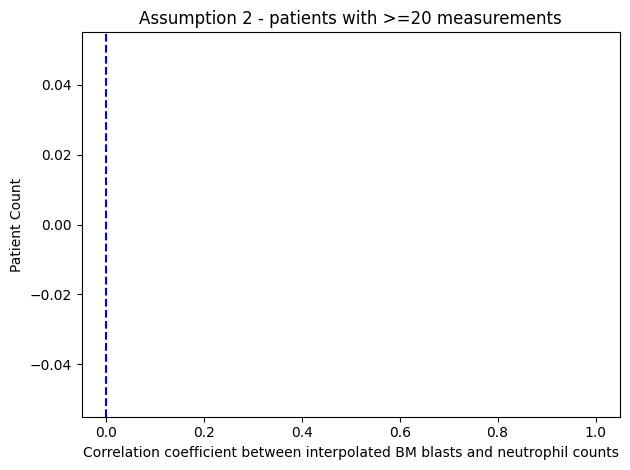

In [48]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations_nointerp.items() if len(patient_data_matched_nointerp[pid]) >=20}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >=20 measurements')
plt.xlabel('Correlation coefficient between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [49]:
len(correlation_subset)

0

In [50]:
if len(correlation_subset) > 0:
    neut_blast_corr_vals = correlation_subset.values()
    positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
    negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
    print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
    print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

In [51]:
import scipy.stats
if len(correlation_subset) > 0:
    scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

#### Pearson - p<0.05

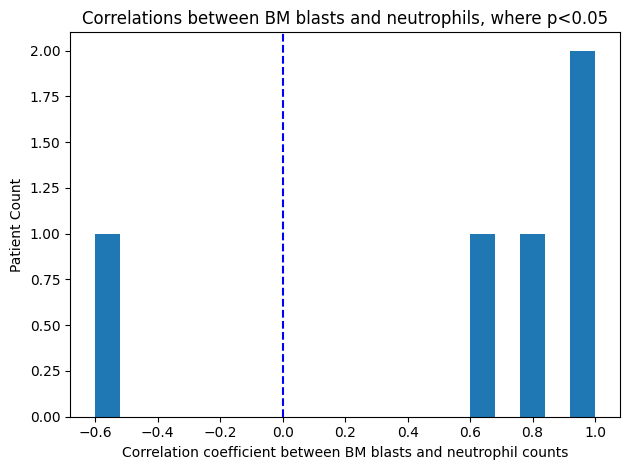

In [52]:
correlation_subset = {pid: x for pid, x in neut_blast_correlations_nointerp.items() if x.pvalue<0.05}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Correlations between BM blasts and neutrophils, where p<0.05')
plt.xlabel('Correlation coefficient between BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [53]:
len(correlation_subset)

5

In [54]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.2 of patients
positive correlations:  0.8 of patients


In [55]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=1, n=5, alternative='two-sided', statistic=0.2, pvalue=0.375)

#### Spearman - all patients

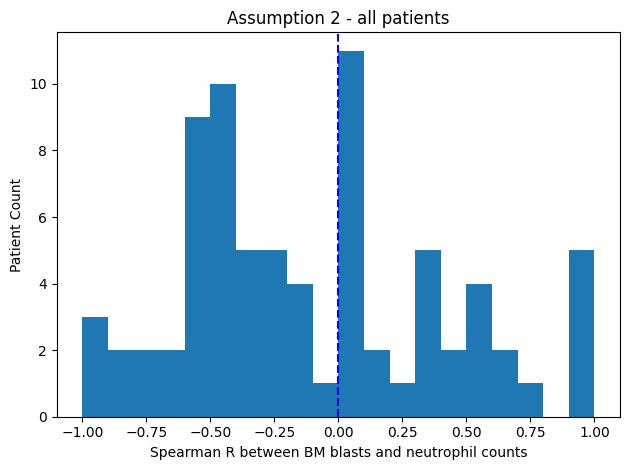

In [56]:
plt.hist([x.statistic for x in neut_blast_spearman_correlations_nointerp.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - all patients')
plt.xlabel('Spearman R between BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [57]:
neut_blast_corr_vals = neut_blast_spearman_correlations_nointerp.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.5375 of patients
positive correlations:  0.3375 of patients


In [58]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=43, n=80, alternative='two-sided', statistic=0.5375, pvalue=0.5764306261883931)

#### Spearman - >5 points

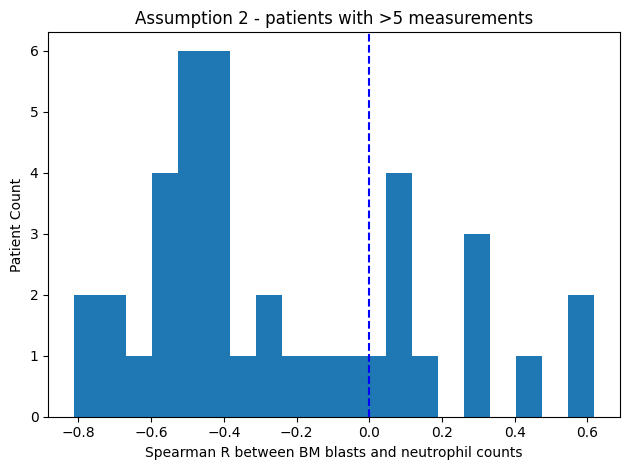

In [59]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations_nointerp.items() if len(patient_data_matched_nointerp[pid]) > 5}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >5 measurements')
plt.xlabel('Spearman R between BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [60]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.675 of patients
positive correlations:  0.3 of patients


In [61]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=27, n=40, alternative='two-sided', statistic=0.675, pvalue=0.03847730828420026)

#### Spearman - >= 20 points

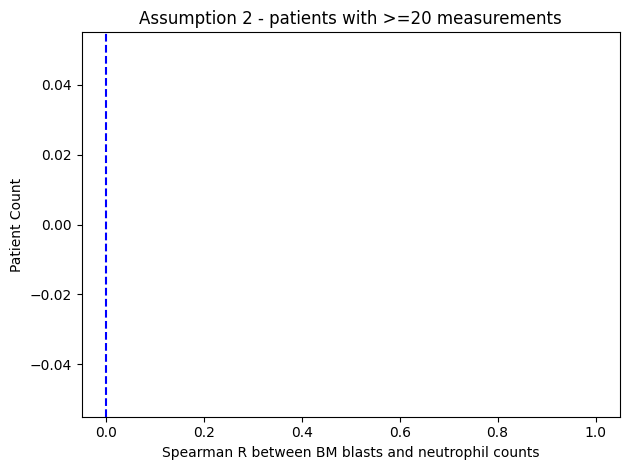

In [62]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations_nointerp.items() if len(patient_data_matched_nointerp[pid]) >= 20}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with >=20 measurements')
plt.xlabel('Spearman R between BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [63]:
if len(s_correlation_subset) > 0:
    neut_blast_corr_vals = s_correlation_subset.values()
    positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
    negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
    print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
    print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

In [64]:
import scipy.stats
if len(s_correlation_subset) > 0:
    scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

#### Spearman - p<0.05

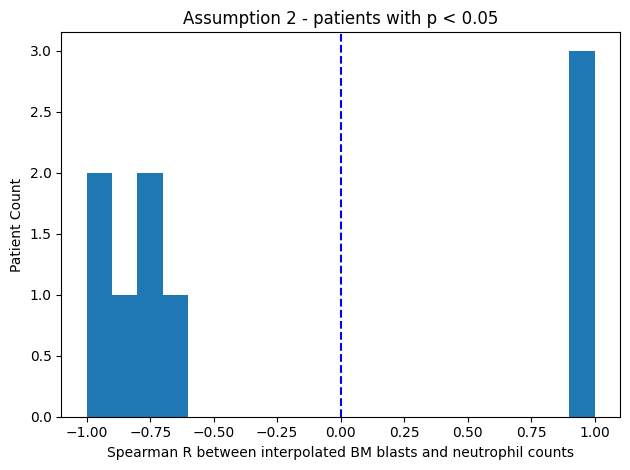

In [65]:
s_correlation_subset = {pid: x for pid, x in neut_blast_spearman_correlations_nointerp.items() if x.pvalue < 0.05}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 2 - patients with p < 0.05')
plt.xlabel('Spearman R between interpolated BM blasts and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [66]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.6666666666666666 of patients
positive correlations:  0.3333333333333333 of patients


In [67]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=6, n=9, alternative='two-sided', statistic=0.6666666666666666, pvalue=0.5078125)

### Neutrophil count vs treatment time

How do neutrophil count vary with last treatment time? Hypothesis: we expect longer time since treatment to correspond to higher neutrophil counts, so we expect a positive correlation between time-since-treatment and neutrophil count. This is because with more time after treatment, there is more time for the neutrophil count to recover after decreasing during the treatment cycle.

In [68]:
# now, do this for all patients...
neut_treatment_correlations = {}
neut_treatment_spearman_correlations = {}
neut_treatment_matched = {}
for patient_id in patient_ids:
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
                                                        bm_blasts, cycle_days, patient_id, use_neut=True)

    cycle_end_dates = []
    for i, row in leuk_table.iterrows():
        past_cycles = cycle_info[(cycle_info['days_ven_start'] < row['days_lab'])].sort_values('days_ven_stop')
        if len(past_cycles) > 0:
            past_cycles = past_cycles.reset_index()
            last_cycle = past_cycles.iloc[-1]
            last_end_date = last_cycle.days_ven_stop
            cycle_end_dates.append(last_end_date)
        else:
            cycle_end_dates.append(0)

    if len(leuk_table) <= 2 or len(blast_table) <= 2:
        continue

    # match lab results to cycle end dates
    # TODO: what if the lab measurement time is in the middle of a cycle???
    # maybe in that case we should just remove the data point? oh wait, it's already removed...
    lab_results_cycles = leuk_table.copy()
    lab_results_cycles['cycle_end_dates'] = cycle_end_dates
    # remove cycle end dates that are 0
    lab_results_cycles = lab_results_cycles[lab_results_cycles['cycle_end_dates'] > 0]
    lab_results_cycles['time_after_cycle'] = lab_results_cycles['days_lab'] - lab_results_cycles['cycle_end_dates']
    # remove points that are within cycles
    lab_results_cycles = lab_results_cycles[lab_results_cycles['time_after_cycle'] > 0]
    if len(lab_results_cycles) < 2:
        continue
    neut_treatment_matched[patient_id] = lab_results_cycles

    correlation = scipy.stats.pearsonr(lab_results_cycles['b_neut'], lab_results_cycles['time_after_cycle'])
    neut_treatment_correlations[patient_id] = correlation
    neut_treatment_spearman_correlations[patient_id] = scipy.stats.spearmanr(lab_results_cycles['b_neut'],
                                                                lab_results_cycles['time_after_cycle'])

#### Pearson - all patients

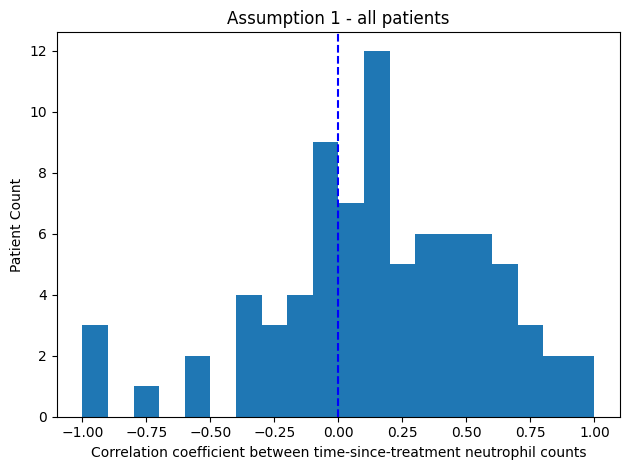

In [69]:
plt.hist([x.statistic for x in neut_treatment_correlations.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - all patients')
plt.xlabel('Correlation coefficient between time-since-treatment neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [70]:
neut_blast_corr_vals = neut_treatment_correlations.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.325 of patients
positive correlations:  0.675 of patients


In [71]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=26, n=80, alternative='two-sided', statistic=0.325, pvalue=0.002324541288088704)

#### Pearson - >5 patients

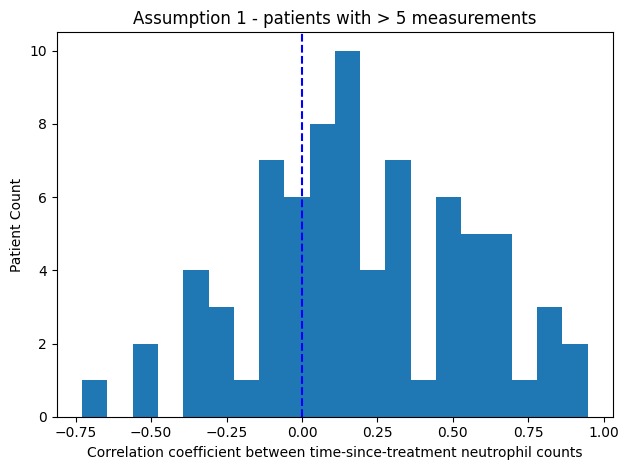

In [72]:
correlation_subset = {pid: x for pid, x in neut_treatment_correlations.items() if len(patient_data[pid]) > 5}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with > 5 measurements')
plt.xlabel('Correlation coefficient between time-since-treatment neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [73]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.3026315789473684 of patients
positive correlations:  0.6973684210526315 of patients


In [74]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=23, n=76, alternative='two-sided', statistic=0.3026315789473684, pvalue=0.0007645817391550476)

#### Pearson - >=20 points

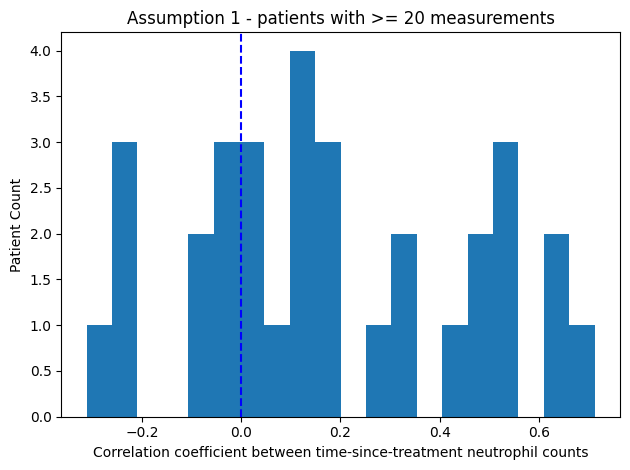

In [75]:
correlation_subset = {pid: x for pid, x in neut_treatment_correlations.items() if len(patient_data[pid]) >= 20}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with >= 20 measurements')
plt.xlabel('Correlation coefficient between time-since-treatment neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [76]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.28125 of patients
positive correlations:  0.71875 of patients


In [77]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=9, n=32, alternative='two-sided', statistic=0.28125, pvalue=0.020061607006937265)

#### Pearson - p<0.05 only

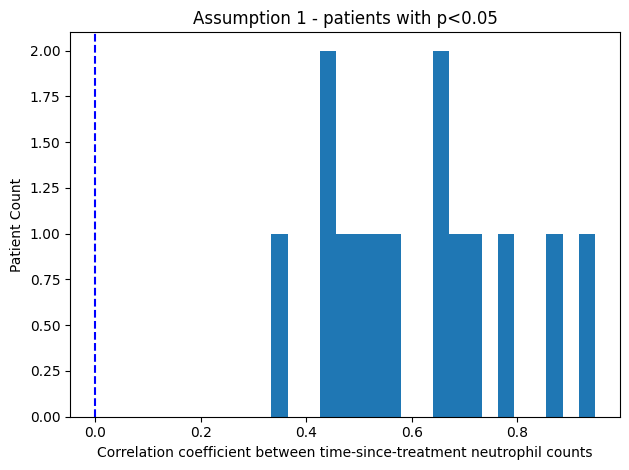

In [78]:
correlation_subset = {pid: x for pid, x in neut_treatment_correlations.items() if x.pvalue<0.05}
plt.hist([x.statistic for x in correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with p<0.05')
plt.xlabel('Correlation coefficient between time-since-treatment neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [79]:
neut_blast_corr_vals = correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.0 of patients
positive correlations:  1.0 of patients


In [80]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=0, n=14, alternative='two-sided', statistic=0.0, pvalue=0.0001220703125)

#### Spearman - all patients

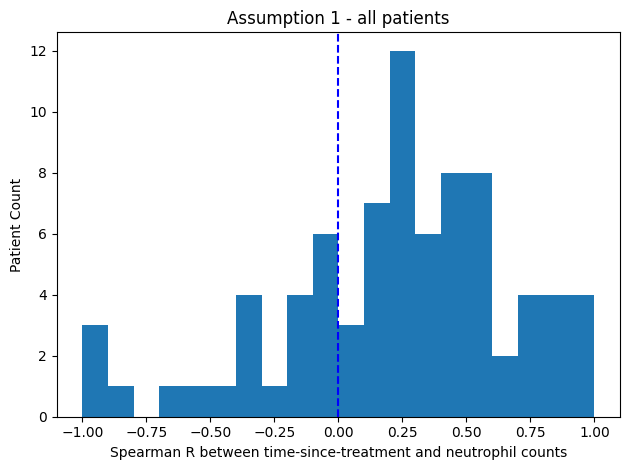

In [81]:
plt.hist([x.statistic for x in neut_treatment_spearman_correlations.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - all patients')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [82]:
neut_blast_corr_vals = neut_treatment_spearman_correlations.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.2625 of patients
positive correlations:  0.725 of patients


In [83]:
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=21, n=80, alternative='two-sided', statistic=0.2625, pvalue=2.5291102564670602e-05)

#### Spearman - >5 points

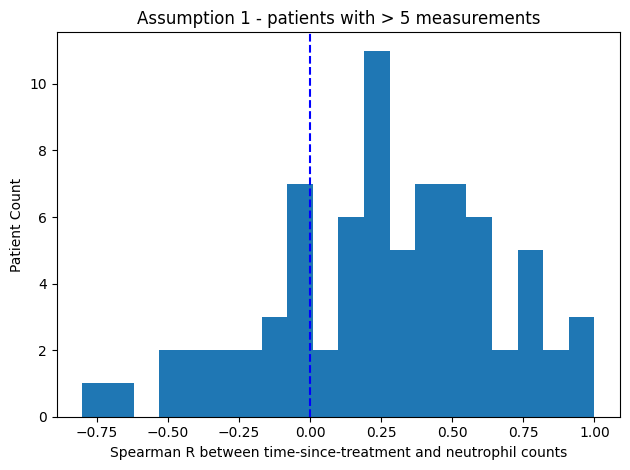

In [84]:
s_correlation_subset = {pid: x for pid, x in neut_treatment_spearman_correlations.items() if len(patient_data[pid]) > 5}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with > 5 measurements')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [85]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.23684210526315788 of patients
positive correlations:  0.75 of patients


In [86]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=18, n=76, alternative='two-sided', statistic=0.23684210526315788, pvalue=4.713242239575157e-06)

#### Spearman - >=20 points

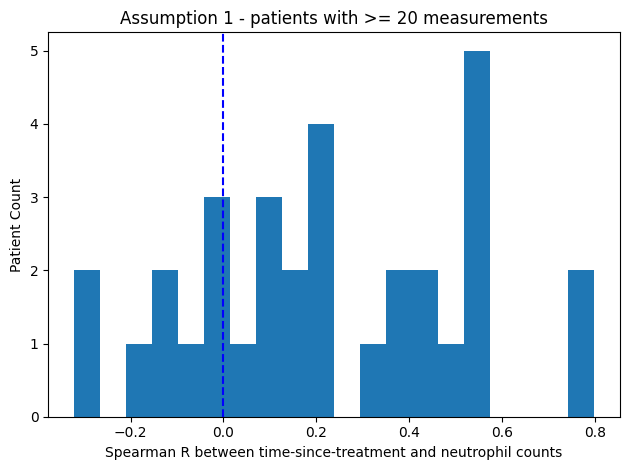

In [87]:
s_correlation_subset = {pid: x for pid, x in neut_treatment_spearman_correlations.items() if len(patient_data[pid]) >= 20}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - patients with >= 20 measurements')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [88]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.25 of patients
positive correlations:  0.75 of patients


In [89]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=8, n=32, alternative='two-sided', statistic=0.25, pvalue=0.0070003666914999485)

In [90]:
print(s_correlation_subset)

{8013: SignificanceResult(statistic=-0.3218420095315425, pvalue=0.1441115251181554), 6067: SignificanceResult(statistic=0.0332028256778757, pvalue=0.8388300718907626), 3101: SignificanceResult(statistic=-0.123244565615962, pvalue=0.3938333753209967), 9145: SignificanceResult(statistic=0.46207304448236125, pvalue=0.0007299287942096979), 5157: SignificanceResult(statistic=0.12132480668213931, pvalue=0.6003635839098327), 5161: SignificanceResult(statistic=-0.0572690781144967, pvalue=0.8158596591262528), 8216: SignificanceResult(statistic=0.002825588751164789, pvalue=0.9839794645240962), 8242: SignificanceResult(statistic=0.21955532280226056, pvalue=0.2811786018207369), 9357: SignificanceResult(statistic=0.32507739938080493, pvalue=0.188084781422369), 6416: SignificanceResult(statistic=0.5552839088671836, pvalue=8.919565565411668e-06), 3447: SignificanceResult(statistic=-0.019297842676761455, pvalue=0.9022442066279386), 2467: SignificanceResult(statistic=0.11855978855411226, pvalue=0.44337

#### Spearman - p<0.05 only

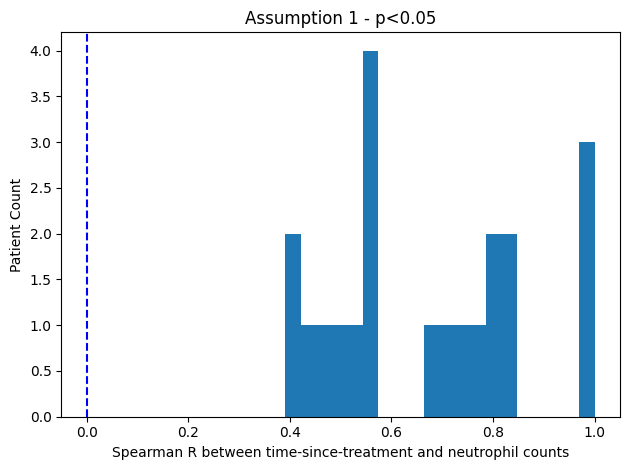

In [91]:
s_correlation_subset = {pid: x for pid, x in neut_treatment_spearman_correlations.items() if x.pvalue < 0.05}
plt.hist([x.statistic for x in s_correlation_subset.values()], bins=20)
plt.axvline(0, color='blue', linestyle='--', label='zero')
plt.title('Assumption 1 - p<0.05')
plt.xlabel('Spearman R between time-since-treatment and neutrophil counts')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()

In [92]:
neut_blast_corr_vals = s_correlation_subset.values()
positive_corr = sum([x.statistic > 0 for x in neut_blast_corr_vals])
negative_corr = sum([x.statistic < 0 for x in neut_blast_corr_vals])
print('negative correlations: ', negative_corr/len(neut_blast_corr_vals), 'of patients')
print('positive correlations: ', positive_corr/len(neut_blast_corr_vals), 'of patients')

negative correlations:  0.0 of patients
positive correlations:  1.0 of patients


In [93]:
# p-value for binomial test of proportion of negative correlations
import scipy.stats
scipy.stats.binomtest(negative_corr, len(neut_blast_corr_vals))

BinomTestResult(k=0, n=21, alternative='two-sided', statistic=0.0, pvalue=9.5367431640625e-07)

In [94]:
print(s_correlation_subset)

{5055: SignificanceResult(statistic=1.0, pvalue=0.0), 6074: SignificanceResult(statistic=0.8108437164260032, pvalue=0.02691632884316199), 9145: SignificanceResult(statistic=0.46207304448236125, pvalue=0.0007299287942096979), 8205: SignificanceResult(statistic=0.6720183486238532, pvalue=0.02351400360535858), 9250: SignificanceResult(statistic=1.0, pvalue=0.0), 7402: SignificanceResult(statistic=0.7473750653575146, pvalue=0.0005638321032131257), 6416: SignificanceResult(statistic=0.5552839088671836, pvalue=8.919565565411668e-06), 5568: SignificanceResult(statistic=0.5736802500013665, pvalue=0.0003896074761275511), 8574: SignificanceResult(statistic=0.8328305948416885, pvalue=0.0027778892723005944), 3631: SignificanceResult(statistic=0.5106843806702979, pvalue=0.03033712510255466), 3652: SignificanceResult(statistic=0.44382706190729015, pvalue=0.006698788314540513), 1666: SignificanceResult(statistic=0.4029081763314348, pvalue=0.0030621937816044794), 8725: SignificanceResult(statistic=0.5

#### Conclusions

- Overall, the correlation seems weaker, with no noticeable change in patients with more time points
- But there is still a significant majority of patients that fit Assumption 1!
- Spearman correlation is more positive than Pearson correlation
- 100% of patients with "significant" (lol) correlations as measured by p<0.05 have very positive correlations, Pearson or Spearman. This is good, probably?

### Saving correlation results

### Saving correlation results

In [95]:
corr_tables = []
for pid in patient_ids:
    if pid not in neut_blast_correlations or pid not in neut_treatment_correlations:
        continue
    neut_blast_pearsonr = neut_blast_correlations[pid].statistic
    neut_blast_spearmanr = neut_blast_spearman_correlations[pid].statistic
    neut_treatment_pearsonr = neut_treatment_correlations[pid].statistic
    neut_treatment_spearmanr = neut_treatment_spearman_correlations[pid].statistic
    if pid not in neut_blast_correlations_nointerp:
        neut_blast_nointerp_pearsonr = np.nan
        neut_blast_nointerp_spearmanr = np.nan
    else:
        neut_blast_nointerp_pearsonr = neut_blast_correlations_nointerp[pid].statistic
        neut_blast_nointerp_spearmanr = neut_blast_spearman_correlations_nointerp[pid].statistic
    if pid not in neut_blast_correlations_nointerp_10_window:
        neut_blast_nointerp_pearsonr_10_window = np.nan
        neut_blast_nointerp_spearmanr_10_window = np.nan
    else:
        neut_blast_nointerp_pearsonr_10_window = neut_blast_correlations_nointerp_10_window[pid].statistic
        neut_blast_nointerp_spearmanr_10_window = neut_blast_spearman_correlations_nointerp_10_window[pid].statistic
    if pid not in neut_blast_correlations_nointerp_2_window:
        neut_blast_nointerp_pearsonr_2_window = np.nan
        neut_blast_nointerp_spearmanr_2_window = np.nan
    else:
        neut_blast_nointerp_pearsonr_2_window = neut_blast_correlations_nointerp_2_window[pid].statistic
        neut_blast_nointerp_spearmanr_2_window = neut_blast_spearman_correlations_nointerp_2_window[pid].statistic

    neut_blast_pearsonr_pval = neut_blast_correlations[pid].pvalue
    neut_blast_spearmanr_pval = neut_blast_spearman_correlations[pid].pvalue
    neut_treatment_pearsonr_pval = neut_treatment_correlations[pid].pvalue
    neut_treatment_spearmanr_pval = neut_treatment_spearman_correlations[pid].pvalue
    if pid not in neut_blast_correlations_nointerp:
        neut_blast_nointerp_pearsonr_pval = np.nan
        neut_blast_nointerp_spearmanr_pval = np.nan
    else:
        neut_blast_nointerp_pearsonr_pval = neut_blast_correlations_nointerp[pid].pvalue
        neut_blast_nointerp_spearmanr_pval = neut_blast_spearman_correlations_nointerp[pid].pvalue
    if pid not in neut_blast_correlations_nointerp_10_window:
        neut_blast_nointerp_pearsonr_pval_10_window = np.nan
        neut_blast_nointerp_spearmanr_pval_10_window = np.nan
    else:
        neut_blast_nointerp_pearsonr_pval_10_window = neut_blast_correlations_nointerp_10_window[pid].pvalue
        neut_blast_nointerp_spearmanr_pval_10_window = neut_blast_spearman_correlations_nointerp_10_window[pid].pvalue
    if pid not in neut_blast_correlations_nointerp_2_window:
        neut_blast_nointerp_pearsonr_pval_2_window = np.nan
        neut_blast_nointerp_spearmanr_pval_2_window = np.nan
    else:
        neut_blast_nointerp_pearsonr_pval_2_window = neut_blast_correlations_nointerp_2_window[pid].pvalue
        neut_blast_nointerp_spearmanr_pval_2_window = neut_blast_spearman_correlations_nointerp_2_window[pid].pvalue
    neut_count = len(patient_data[pid])
    if pid in patient_data_matched_nointerp:
        matched_neut_count = len(patient_data_matched_nointerp[pid])
    else:
        matched_neut_count = 0
    if pid in patient_data_matched_nointerp_10_window:
        matched_neut_count_10_window = len(patient_data_matched_nointerp_10_window[pid])
    else:
        matched_neut_count_10_window = 0
    if pid in patient_data_matched_nointerp_2_window:
        matched_neut_count_2_window = len(patient_data_matched_nointerp_2_window[pid])
    else:
        matched_neut_count_2_window = 0
    corr_tables.append((pid, neut_blast_pearsonr, neut_blast_pearsonr_pval,
                        neut_blast_spearmanr, neut_blast_spearmanr_pval,
                        neut_treatment_pearsonr, neut_treatment_pearsonr_pval,
                        neut_treatment_spearmanr, neut_treatment_spearmanr_pval,
                        neut_blast_nointerp_pearsonr, neut_blast_nointerp_pearsonr_pval,
                        neut_blast_nointerp_spearmanr, neut_blast_nointerp_spearmanr_pval,
                        neut_blast_nointerp_pearsonr_10_window, neut_blast_nointerp_pearsonr_pval_10_window,
                        neut_blast_nointerp_spearmanr_10_window, neut_blast_nointerp_spearmanr_pval_10_window,
                        neut_blast_nointerp_pearsonr_2_window, neut_blast_nointerp_pearsonr_pval_2_window,
                        neut_blast_nointerp_spearmanr_2_window, neut_blast_nointerp_spearmanr_pval_2_window,
                        neut_count, matched_neut_count, matched_neut_count_10_window, matched_neut_count_2_window))

In [96]:
corr_df = pd.DataFrame(corr_tables)
corr_df.columns = ['pid', 'neut_blast_pearsonr', 'neut_blast_pearsonr_pval',
                        'neut_blast_spearmanr', 'neut_blast_spearmanr_pval',
                        'neut_treatment_pearsonr', 'neut_treatment_pearsonr_pval',
                        'neut_treatment_spearmanr','neut_treatment_spearmanr_pval',
                        'neut_blast_nointerp_pearsonr', 'neut_blast_nointerp_pearsonr_pval',
                        'neut_blast_nointerp_spearmanr', 'neut_blast_nointerp_spearmanr_pval',
                        'neut_blast_nointerp_pearsonr_10_window', 'neut_blast_nointerp_pearsonr_pval_10_window',
                        'neut_blast_nointerp_spearmanr_10_window', 'neut_blast_nointerp_spearmanr_pval_10_window',
                        'neut_blast_nointerp_pearsonr_2_window', 'neut_blast_nointerp_pearsonr_pval_2_window',
                        'neut_blast_nointerp_spearmanr_2_window', 'neut_blast_nointerp_spearmanr_pval_2_window',
                        'neut_count', 'matched_neut_count', 'matched_neut_count_10_window', 'matched_neut_count_2_window']

In [97]:
corr_df.to_csv('neut_blast_treatment_correlations_2025_05_09.csv', index=None)

In [98]:
corr_df.mean()

pid                                             5511.150000
neut_blast_pearsonr                               -0.145080
neut_blast_pearsonr_pval                           0.348341
neut_blast_spearmanr                              -0.164847
neut_blast_spearmanr_pval                          0.392391
neut_treatment_pearsonr                            0.158003
neut_treatment_pearsonr_pval                       0.449174
neut_treatment_spearmanr                           0.226446
neut_treatment_spearmanr_pval                      0.331104
neut_blast_nointerp_pearsonr                      -0.066233
neut_blast_nointerp_pearsonr_pval                  0.494034
neut_blast_nointerp_spearmanr                     -0.094089
neut_blast_nointerp_spearmanr_pval                 0.471141
neut_blast_nointerp_pearsonr_10_window            -0.065338
neut_blast_nointerp_pearsonr_pval_10_window        0.484228
neut_blast_nointerp_spearmanr_10_window           -0.078677
neut_blast_nointerp_spearmanr_pval_10_wi

In [99]:
corr_df.median()

pid                                             5250.000000
neut_blast_pearsonr                               -0.234602
neut_blast_pearsonr_pval                           0.270028
neut_blast_spearmanr                              -0.197506
neut_blast_spearmanr_pval                          0.306795
neut_treatment_pearsonr                            0.147668
neut_treatment_pearsonr_pval                       0.411898
neut_treatment_spearmanr                           0.236089
neut_treatment_spearmanr_pval                      0.244965
neut_blast_nointerp_pearsonr                      -0.236481
neut_blast_nointerp_pearsonr_pval                  0.467288
neut_blast_nointerp_spearmanr                     -0.181369
neut_blast_nointerp_spearmanr_pval                 0.497937
neut_blast_nointerp_pearsonr_10_window            -0.221703
neut_blast_nointerp_pearsonr_pval_10_window        0.442954
neut_blast_nointerp_spearmanr_10_window           -0.139167
neut_blast_nointerp_spearmanr_pval_10_wi

In [100]:
corr_df.std()

pid                                             2534.062507
neut_blast_pearsonr                                0.356361
neut_blast_pearsonr_pval                           0.307805
neut_blast_spearmanr                               0.326170
neut_blast_spearmanr_pval                          0.336462
neut_treatment_pearsonr                            0.426741
neut_treatment_pearsonr_pval                       0.336587
neut_treatment_spearmanr                           0.459572
neut_treatment_spearmanr_pval                      0.305176
neut_blast_nointerp_pearsonr                       0.505077
neut_blast_nointerp_pearsonr_pval                  0.302488
neut_blast_nointerp_spearmanr                      0.504289
neut_blast_nointerp_spearmanr_pval                 0.333262
neut_blast_nointerp_pearsonr_10_window             0.487422
neut_blast_nointerp_pearsonr_pval_10_window        0.282391
neut_blast_nointerp_spearmanr_10_window            0.481186
neut_blast_nointerp_spearmanr_pval_10_wi

## Aggregating data across multiple patients

### Aggregated Neutrophil vs blast (H2)

In [101]:
merged_h2_data = pd.concat(patient_data_matched.values())

Text(0, 0.5, 'Neutrophil Count')

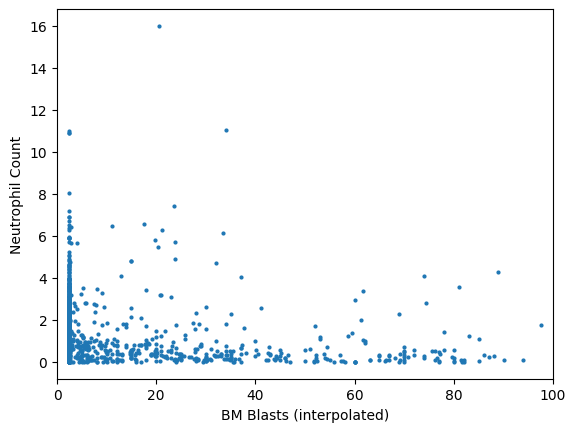

In [102]:
plt.scatter(merged_h2_data.bm_blasts_interpolated, merged_h2_data.b_neut, s=4)
plt.xlim(0, 100)
plt.xlabel('BM Blasts (interpolated)')
plt.ylabel('Neutrophil Count')

In [103]:
scipy.stats.spearmanr(merged_h2_data.b_neut, merged_h2_data.bm_blasts_interpolated)

SignificanceResult(statistic=-0.352154005906386, pvalue=1.813395668394944e-48)

### Aggregated Neutrophil vs time-since-treatment (H1)

In [104]:
merged_h1_data = pd.concat(neut_treatment_matched.values())

Text(0, 0.5, 'Neutrophil Count')

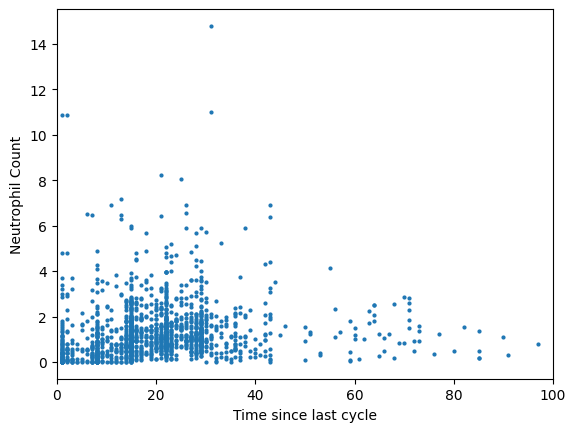

In [105]:
plt.scatter(merged_h1_data.time_after_cycle, merged_h1_data.b_neut, s=4)
plt.xlim(0, 100)
plt.xlabel('Time since last cycle')
plt.ylabel('Neutrophil Count')

In [106]:
scipy.stats.spearmanr(merged_h1_data.b_neut, merged_h1_data.time_after_cycle)

SignificanceResult(statistic=0.22643275600508328, pvalue=3.2303282741405646e-19)

## Crosstabs and statistics

TODO: merging correlations data with patient data

### Summary Statistics of the Hypotheses

In [107]:
# H1 & H2
corr_df.query('neut_treatment_spearmanr > 0 and neut_blast_spearmanr < 0').shape

(39, 10)

In [108]:
# H1 & ~H2
corr_df.query('neut_treatment_spearmanr > 0 and neut_blast_spearmanr >= 0').shape

(17, 10)

In [109]:
# ~H1 & H2
corr_df.query('neut_treatment_spearmanr <= 0 and neut_blast_spearmanr < 0').shape

(16, 10)

In [110]:
# ~H1 & ~H2
corr_df.query('neut_treatment_spearmanr <= 0 and neut_blast_spearmanr >= 0').shape

(6, 10)

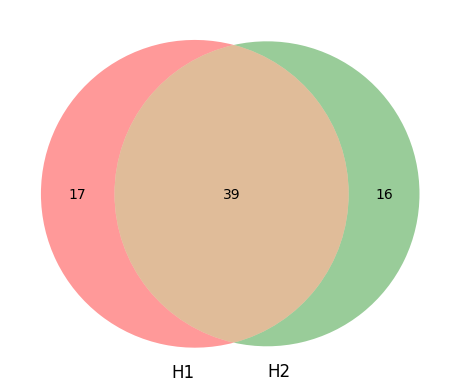

In [111]:
### venn diagrams
from matplotlib_venn import venn2
venn2(subsets=(17, 16, 39), set_labels=['H1', 'H2'])

What about high-resolution patients?

In [112]:
# H1 & H2

corr_df.query('neut_treatment_spearmanr > 0 and neut_blast_spearmanr < 0 and neut_count >= 20').shape

(19, 10)

In [113]:
# ~H1 & H2

corr_df.query('neut_treatment_spearmanr < 0 and neut_blast_spearmanr < 0 and neut_count >= 20').shape

(7, 10)

In [114]:
# H1 & ~H2

corr_df.query('neut_treatment_spearmanr > 0 and neut_blast_spearmanr > 0 and neut_count >= 20').shape

(3, 10)

In [115]:
# ~H1 & ~H2

corr_df.query('neut_treatment_spearmanr <= 0 and neut_blast_spearmanr >= 0 and neut_count >= 20').shape

(1, 10)

Text(0.5, 1.0, 'High-resolution dataset')

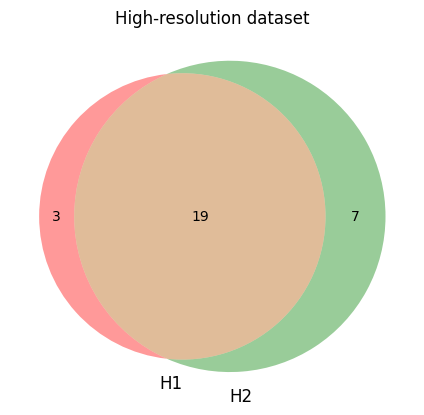

In [116]:
venn2(subsets=(3, 7, 19), set_labels=['H1', 'H2'])
plt.title('High-resolution dataset')

In [117]:
corr_df.neut_treatment_spearmanr.describe()

count    80.000000
mean      0.226446
std       0.459572
min      -1.000000
25%      -0.008261
50%       0.236089
75%       0.521344
max       1.000000
Name: neut_treatment_spearmanr, dtype: float64

In [118]:
corr_df.neut_blast_spearmanr.describe()

count    78.000000
mean     -0.164847
std       0.326170
min      -0.866712
25%      -0.399336
50%      -0.197506
75%       0.022400
max       0.564288
Name: neut_blast_spearmanr, dtype: float64

<Axes: >

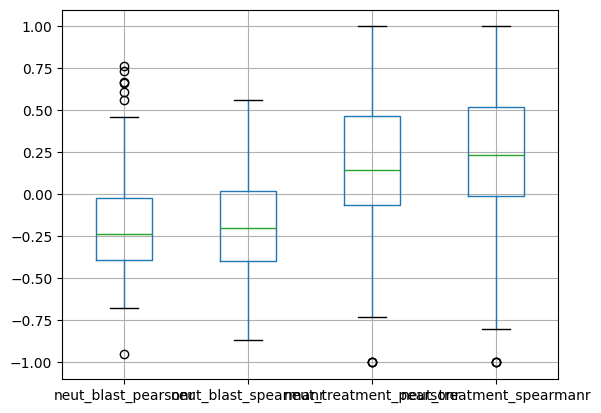

In [119]:
corr_df[['neut_blast_pearsonr',
         'neut_blast_spearmanr',
         'neut_treatment_pearsonr',
         'neut_treatment_spearmanr',]].boxplot()

<Axes: >

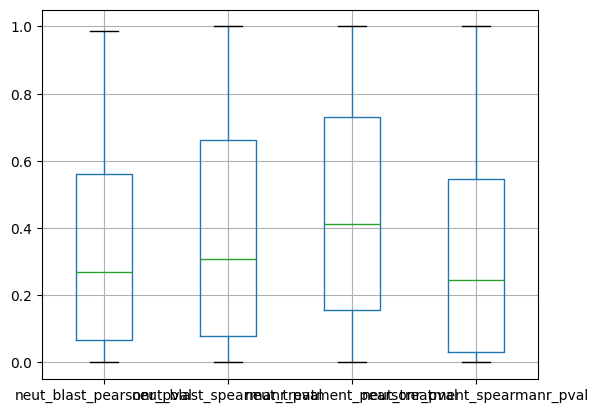

In [90]:
corr_df[['neut_blast_pearsonr_pval',
         'neut_blast_spearmanr_pval',
         'neut_treatment_pearsonr_pval',
         'neut_treatment_spearmanr_pval']].boxplot()

### Loading patient data

Note: patient data is currently not included in this release. Data is available by request from the authors.

In [ ]:
patient_data = pd.read_csv('../patient_data_venex/ven_responses_052023.txt', sep='\t')
patient_data.index = patient_data.Study_subject_Id
corr_df.index = corr_df.pid
merged_data = corr_df.join(patient_data)

In [ ]:
merged_data['h1'] = merged_data.neut_treatment_spearmanr > 0

In [ ]:
merged_data['h2'] = merged_data.neut_blast_spearmanr < 0

### Contingency tables - H1 and H2 vs outcomes

#### H1 vs H2

In [ ]:
pd.crosstab(merged_data.h1, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.h1, merged_data.h2))

This indicates that there is no significant association between H1 and H2.

In [ ]:
pd.crosstab(merged_data.best_response, merged_data.relapse_occurred)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.best_response, merged_data.relapse_occurred))

#### H1 vs best_response

In [ ]:
pd.crosstab(merged_data.best_response, merged_data.h1)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.best_response, merged_data.h1))

#### H1 vs relapse_occurred, status

In [ ]:
pd.crosstab(merged_data.relapse_occurred, merged_data.h1)

In [ ]:
pd.crosstab(merged_data.status, merged_data.h1)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.status, merged_data.h1))

Assumption 1 is not significantly associated with best_response, relapse, or status.

#### H2 vs best_response

In [ ]:
pd.crosstab(merged_data.best_response, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.best_response, merged_data.h2))

This is a significant result!!!

#### H2 vs relapse_occurred, status

In [ ]:
pd.crosstab(merged_data.relapse_occurred, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.relapse_occurred, merged_data.h2))

In [ ]:
pd.crosstab(merged_data.status, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.status, merged_data.h2))

### Hypotheses and clinical variables

#### H1 & gender, age, prev AML, FAB, ECOG

In [ ]:
pd.crosstab(merged_data.Gender, merged_data.h1)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.Gender, merged_data.h1))

In [ ]:
pd.crosstab(merged_data.age_group_scr, merged_data.h1)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.age_group_scr, merged_data.h1))

In [ ]:
pd.crosstab(merged_data.incl_dg_for_tables, merged_data.h1)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.incl_dg_for_tables, merged_data.h1))

In [ ]:
pd.crosstab(merged_data.fab, merged_data.h1)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.fab, merged_data.h1))

In [ ]:
pd.crosstab(merged_data.ecog_scr, merged_data.h1)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.ecog_scr, merged_data.h1))

H1 is not associated with a single clinical variable.

#### H2 & gender, age, prev AML, FAB, ECOG

In [ ]:
pd.crosstab(merged_data.Gender, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.Gender, merged_data.h2))

In [ ]:
pd.crosstab(merged_data.age_group_scr, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.age_group_scr, merged_data.h2))

In [ ]:
pd.crosstab(merged_data.incl_dg_for_tables, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.incl_dg_for_tables, merged_data.h2))

In [ ]:
pd.crosstab(merged_data.fab, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.fab, merged_data.h2))

In [ ]:
pd.crosstab(merged_data.ecog_scr, merged_data.h2)

In [ ]:
scipy.stats.chi2_contingency(pd.crosstab(merged_data.ecog_scr, merged_data.h2))

### Continuous statistics (using correlations)

#### H1 vs outcome variables

In [ ]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='best_response')

In [ ]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='status')

#### H1 vs a priori variables

In [ ]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='incl_dg_for_tables')

In [ ]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='ecog_scr')

In [ ]:
merged_data.boxplot(column='neut_treatment_spearmanr', by='fab')

#### H2 vs outcome variables

In [ ]:
merged_data.boxplot(column='neut_blast_spearmanr', by='best_response')

In [ ]:
merged_data.boxplot(column='neut_blast_spearmanr', by='status')

#### H2 vs a priori variables

In [ ]:
merged_data.boxplot(column='neut_blast_spearmanr', by='incl_dg_for_tables')

In [ ]:
merged_data.boxplot(column='neut_blast_spearmanr', by='ecog_scr')

In [ ]:
merged_data.boxplot(column='neut_blast_spearmanr', by='fab')